# 7. Extracting Information from Text

Now that we've looked at lots of data and thought about how to code it - let's see if we can answer these questions:

- How can we build a system that extracts structured data, such as tables, from unstructured text?
- What are some robust methods for identifying the entities and relationships described in a text?
- Which corpora are appropriate for this work, and how do we use them for training and evaluating our models?


# 1 Information Extraction

- Structured data: regular and predictable relationship between entities
- For example, the relationship between you, your email, and your course registration is structured.
    - If you can put it easily into a table, it's structured.
- However, a lot of data isn't actually set up that way. 

"The fourth Wells account moving to another agency is the packaged paper-products division of Georgia-Pacific Corp., which arrived at Wells only last fall. Like Hertz and the History Channel, it is also leaving for an Omnicom-owned agency, the BBDO South unit of BBDO Worldwide. BBDO South in Atlanta, which handles corporate advertising for Georgia-Pacific, will assume additional duties for brands like Angel Soft toilet tissue and Sparkle paper towels, said Ken Haldin, a spokesman for Georgia-Pacific in Atlanta."

- Unstructured data: natural language sentences that tell you the relationship but you have to extract it from the data. 

# 1.1 Information Extraction Architecture

- Named entity detection: segmenting and labeling entities that may be useful for your relation detection
- Relation detection is finding those links between entities

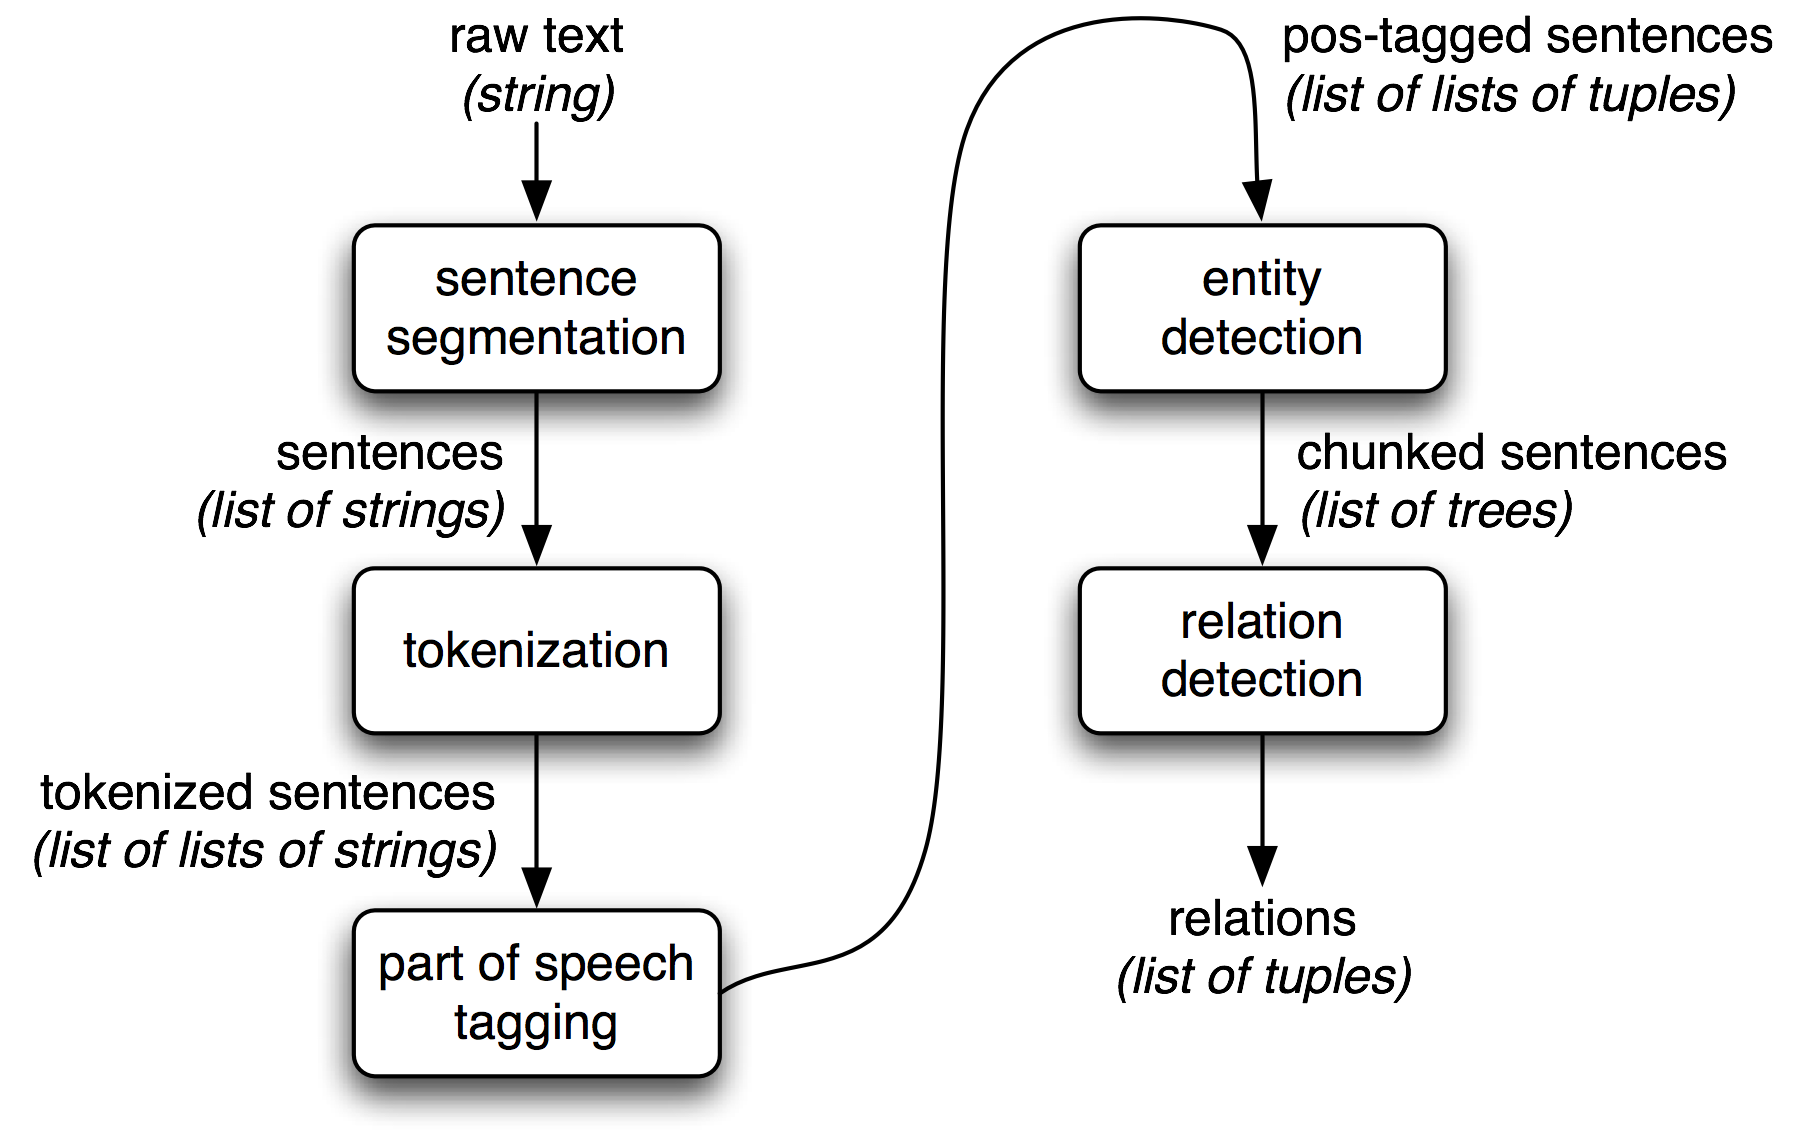

In [1]:
from IPython.display import Image
Image("lesson7-arch.png")

# 2 Chunking

- Chunking: segmenting and labeling sequences of words as shown below
    - Small chunks may be the POS tagged sections
    - Larger chunks include the structure of the sentences like noun phrases and verb phrases

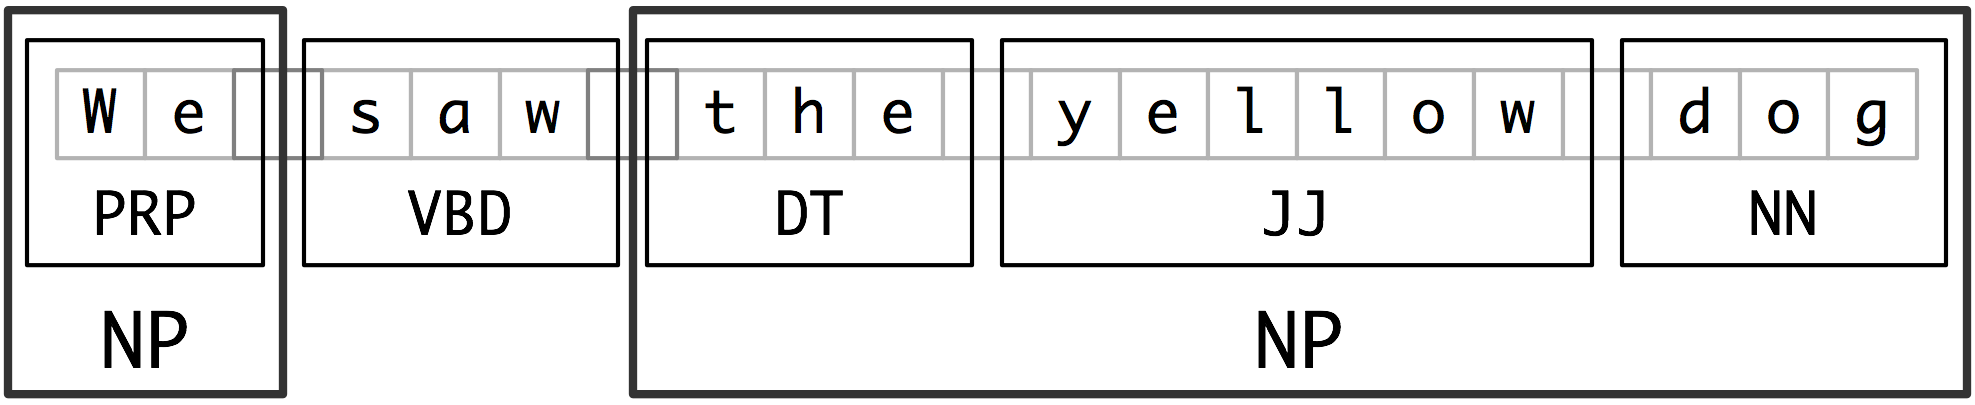

In [4]:
Image("lesson7-chunk.png")

# 2.1 Noun Phrase Chunking

- NP Chunking: searching for chunks that are individual noun phrases

Example: [ The/DT market/NN ] for/IN [ system-management/NN software/NN ] for/IN [ Digital/NNP ] [ 's/POS hardware/NN ] is/VBZ fragmented/JJ enough/RB that/IN [ a/DT giant/NN ] such/JJ as/IN [ Computer/NNP Associates/NNPS ] should/MD do/VB well/RB there/RB ./.

- Example: *the market for system-management software for Digital's hardware* is a single noun phrase 
- NP-chunks break this into smaller sub-chunks like *the market* to keep chunks orthogonal (separate)

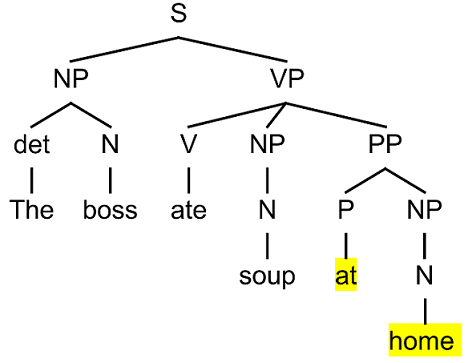

In [9]:
Image("lesson7-tree.png")

- Start with a sentence that has been part of speech tagged
- Create a grammar rule: NP-chunks created by determiner followed by adjectives and then a noun
- Create a chunk parser
- Test it!

In [7]:
import nltk, re

#tagged sentence
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),
            ("dog", "NN"), ("barked", "VBD"), ("at", "IN"),  ("the", "DT"), ("cat", "NN")]

#chunk rule
grammar = "NP: {<DT>?<JJ>*<NN>}"

#create a parser based on regular expressions
cp = nltk.RegexpParser(grammar) 

In [37]:
#test it!
result = cp.parse(sentence)
#print the parse format
print(result)
#print the parse tree
result.draw()

(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))


# 2.2 Tag Patterns

- Tag patterns describe a sequence of tagged words
- The patterns are delimited using angle brackets and regex 
- `<DT><JJ>` would be a determiner followed by an adjective
- `<DT>?<JJ.*>*<NN.*>+`: Optional determiner, any number of adjective types, with one or more nouns

# 2.3 Chunking with Regular Expressions

- We can use the `RegexpParser` to chunk a set of sentences. 
- First, it says there is no structure in the sentence.
- Then the rules are applied one at a time, updating the structure.
- Let's look at one with two rules:
    - `{<DT|PP\$>?<JJ>*<NN>}`
    - `{<NNP>+}`

In [11]:
grammar = r"""
  NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun PP$ is a special symbol
      {<NNP>+}                # chunk sequences of proper nouns
      """
cp = nltk.RegexpParser(grammar)
sentence = [("Rapunzel", "NNP"), ("let", "VBD"), ("down", "RP"),
                 ("her", "PP$"), ("long", "JJ"), ("golden", "JJ"), ("hair", "NN")]

In [12]:
print(cp.parse(sentence))

(S
  (NP Rapunzel/NNP)
  let/VBD
  down/RP
  (NP her/PP$ long/JJ golden/JJ hair/NN))


- What happens when the chunks would overlap based on our rules?
- The leftmost match takes precedence. 
- For example, if we had three nouns in a row, but the rule was find two nouns .. you would end up with a chunk that has two nouns and then a separate one noun chunk.

In [13]:
nouns = [("money", "NN"), ("market", "NN"), ("fund", "NN")]
grammar = "NP: {<NN><NN>}  # Chunk two consecutive nouns"
cp = nltk.RegexpParser(grammar)
print(cp.parse(nouns))

(S (NP money/NN market/NN) fund/NN)


# 2.5 Chinking

- A chink is a sequence of tokens that is not included in the chunk
- Think of this as "a chink in the armor" or a crack/gap or missing piece
- If the sequence matches:
    - Completely: the whole chunk is removed
    - In the middle of the chunk: just the section is removed and left over is two new chunks
    - At the beginning/end of the chunk: they are removed and the rest of the chunk stays

In [15]:
grammar = r"""
  NP:
    {<.*>+}          # Chunk everything
    }<VBD|IN>+{      # Chink sequences of VBD and IN
  """
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),
       ("dog", "NN"), ("barked", "VBD"), ("at", "IN"),  ("the", "DT"), ("cat", "NN")]
cp = nltk.RegexpParser(grammar)
print(cp.parse(sentence))

(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))


# 2.6 Representing Chunks: Tags vs Trees

- You can represent chunks as tags or trees, most commonly this is done as IOB tags.
    - I: inside the chunk
    - O: outside the chunk
    - B: beginning of the chunk 

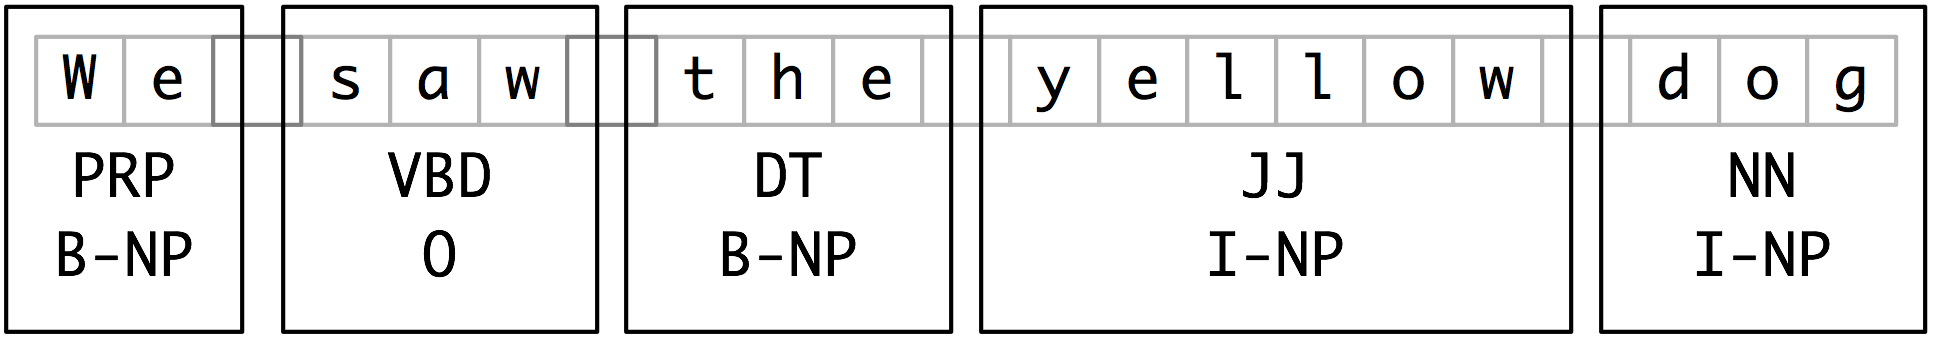

In [16]:
Image("lesson7-chunk2.png")

# 3 Developing and Evaluating Chunkers

- The same set of steps we have done before:
    - Create the features / chunking rules
    - Create a train and test dataset
    - Train the chunker
    - Test the accuracy of the chunker

# 3.1 Reading IOB Format and the CoNLL 2000 Corpus

- Each line in the CoNLL corpus is a word with the part of speech tag and the IOB code
- You can use `chunk.conllstr2tree()` to create a tree of this type of data


In [40]:
text = '''
he PRP B-NP
accepted VBD B-VP
the DT B-NP
position NN I-NP
of IN B-PP
vice NN B-NP
chairman NN I-NP
of IN B-PP
Carlyle NNP B-NP
Group NNP I-NP
, , O
a DT B-NP
merchant NN I-NP
banking NN I-NP
concern NN I-NP
. . O
'''
nltk.chunk.conllstr2tree(text, chunk_types=['VP']).draw()

# 3.2 Simple Evaluation and Baselines

- We are going establish a baseline chunker that doesn't do any chunking as a metric to score against
- Then slowly add our feature sets to see if we can do better. 

In [22]:
#open up the tagged corpus
from nltk.corpus import conll2000

#a blank parser trained with ""
cp = nltk.RegexpParser("")

#create a test set - these are already broken up in this corpus
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

#print out the accuracy, precision, recall, and F score
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


Interpreting the output:
- IOB accuracy is the number of IOB tags marked correctly - here about 43% because everything was marked O
- Precision, recall, and f-measure we talked about last week - since there are no chunks found, we have zeros here. 

In [24]:
#now let's try training with normal NP markers
grammar = r"NP: {<[CDJNP].*>+}" #starts with CD DT JJ

#train the chunker
cp = nltk.RegexpParser(grammar)

#evaluate
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%


- This example is a simple regular expression parser ... so good for specific circumstances, but doesn't actually "train" based on our corpus
- Instead, let's try the `UnigramChunker`, which is a trainer, much like the UnigramTagger from part of speech tagging

In [27]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents): 
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data) 

    def parse(self, sentence): 
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

What is this doing?
- Inputs a list of training sentences 
- Converts to the form of word, tag, IOB
- Creates a unigram tagger
- Defines parse as the way to take a new sentence and add tags

In [28]:
#separate out test and train
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])

#train the unigram chunker
unigram_chunker = UnigramChunker(train_sents)

#test it!
print(unigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


In [30]:
postags = sorted(set(pos for sent in train_sents
                      for (word,pos) in sent.leaves()))
print(unigram_chunker.tagger.tag(postags))

#punctuation is on the outside
#DT PRP WP are at the beginning of NP
#NN inside NP

[('#', 'B-NP'), ('$', 'B-NP'), ("''", 'O'), ('(', 'O'), (')', 'O'), (',', 'O'), ('.', 'O'), (':', 'O'), ('CC', 'O'), ('CD', 'I-NP'), ('DT', 'B-NP'), ('EX', 'B-NP'), ('FW', 'I-NP'), ('IN', 'O'), ('JJ', 'I-NP'), ('JJR', 'B-NP'), ('JJS', 'I-NP'), ('MD', 'O'), ('NN', 'I-NP'), ('NNP', 'I-NP'), ('NNPS', 'I-NP'), ('NNS', 'I-NP'), ('PDT', 'B-NP'), ('POS', 'B-NP'), ('PRP', 'B-NP'), ('PRP$', 'B-NP'), ('RB', 'O'), ('RBR', 'O'), ('RBS', 'B-NP'), ('RP', 'O'), ('SYM', 'O'), ('TO', 'O'), ('UH', 'O'), ('VB', 'O'), ('VBD', 'O'), ('VBG', 'O'), ('VBN', 'O'), ('VBP', 'O'), ('VBZ', 'O'), ('WDT', 'B-NP'), ('WP', 'B-NP'), ('WP$', 'B-NP'), ('WRB', 'O'), ('``', 'O')]


# 3.3 Training Classifier-Based Chunkers

- We've used a regular expression and n-gram tagger above
- We learned classifiers in the last chapter - can we use those to help us chunk?
- These taggers are especially good when the *content* matters rather than just the part of speech

In [35]:
#a classifier based tagger using a maxentclassifier rather than bayes
class ConsecutiveNPChunkTagger(nltk.TaggerI):

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.MaxentClassifier.train( 
            train_set, algorithm='iis', trace=0)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI): 
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [36]:
#define the features mostly part of speech
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos}

#train your chunker built above
chunker = ConsecutiveNPChunker(train_sents)

#evaluate
print(chunker.evaluate(test_sents))

      Training stopped: keyboard interrupt
ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


What does all this have to do with naming and relation extraction?
- You can chunk your data and look for NP
- You can tag the data with *named entities* using the `treebank` corpus, which will tag them as person, organization, and location.
- Once you have named entities, you can look for patterns like:
    - Apple located in New York
    - Organization "IN" Location